In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasa-nearest-earth-objects-1910-2024/nearest-earth-objects(1910-2024).csv


# Import Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

# Load the Data

In [3]:
df = pd.read_csv("/kaggle/input/nasa-nearest-earth-objects-1910-2024/nearest-earth-objects(1910-2024).csv")

In [4]:
df.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


# Check of Data

In [5]:
df.shape

(338199, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB


In [7]:
df.isnull().sum()

neo_id                     0
name                       0
absolute_magnitude        28
estimated_diameter_min    28
estimated_diameter_max    28
orbiting_body              0
relative_velocity          0
miss_distance              0
is_hazardous               0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df["orbiting_body"].value_counts()

orbiting_body
Earth    338199
Name: count, dtype: int64

In [10]:
df["name"].value_counts()

name
277810 (2006 FV35)               211
469219 Kamo`oalewa (2016 HO3)    197
(2014 OL339)                     192
(2017 FZ2)                       186
(2023 FW13)                      169
                                ... 
(2024 MX)                          1
(2024 LR2)                         1
(2024 MW1)                         1
(2024 MY1)                         1
(2024 MR1)                         1
Name: count, Length: 33514, dtype: int64

# Exploratory Data Anlaysis (EDA)

In [11]:
numerical_summary = df.describe().transpose()

palette = sns.color_palette("viridis", as_cmap=True)

numerical_summary.style.background_gradient(cmap=palette)

,count,mean,std,min,25%,50%,75%,max
neo_id,338199.000000,17599388.682019,22872246.428932,2000433.000000,3373980.000000,3742127.000000,54053736.500000,54462807.000000
absolute_magnitude,338171.000000,22.932525,2.911216,9.250000,20.740000,22.800000,25.100000,33.580000
estimated_diameter_min,338171.000000,0.157812,0.313885,0.000511,0.025384,0.073207,0.189041,37.545248
estimated_diameter_max,338171.000000,0.352878,0.701869,0.001143,0.056760,0.163697,0.422708,83.953727
relative_velocity,338199.000000,51060.662908,26399.238435,203.346433,30712.031471,47560.465474,66673.820614,291781.106613
miss_distance,338199.000000,41535350.932190,20773990.246102,6745.532516,24945397.527133,43326743.828348,59339605.219975,74798651.452197


In [12]:
pd.DataFrame(df["name"].value_counts()[0:10])

,count
name,
277810 (2006 FV35),211
469219 Kamo`oalewa (2016 HO3),197
(2014 OL339),192
(2017 FZ2),186
(2023 FW13),169
(2022 YF4),151
164207 (2004 GU9),135
85770 (1998 UP1),101
138852 (2000 WN10),99


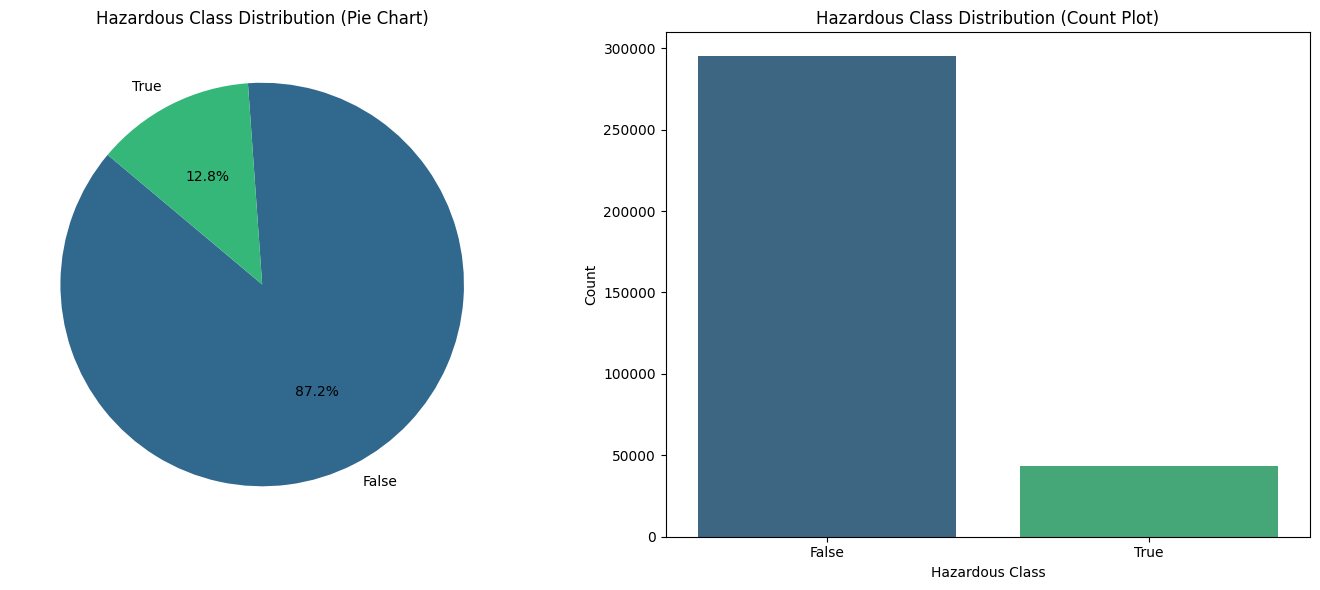

In [13]:
hazardous_counts = df['is_hazardous'].value_counts().sort_index()

palette = sns.color_palette("viridis", n_colors=len(hazardous_counts))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.pie(hazardous_counts, labels=df["is_hazardous"].unique(), autopct='%1.1f%%', startangle=140, colors=palette)
ax1.set_title('Hazardous Class Distribution (Pie Chart)')
sns.countplot(x='is_hazardous', data=df, ax=ax2, palette=palette)
ax2.set_title('Hazardous Class Distribution (Count Plot)')
ax2.set_xlabel('Hazardous Class')
ax2.set_ylabel('Count')
ax2.set_xticklabels(df["is_hazardous"].unique())
plt.tight_layout()
plt.show()

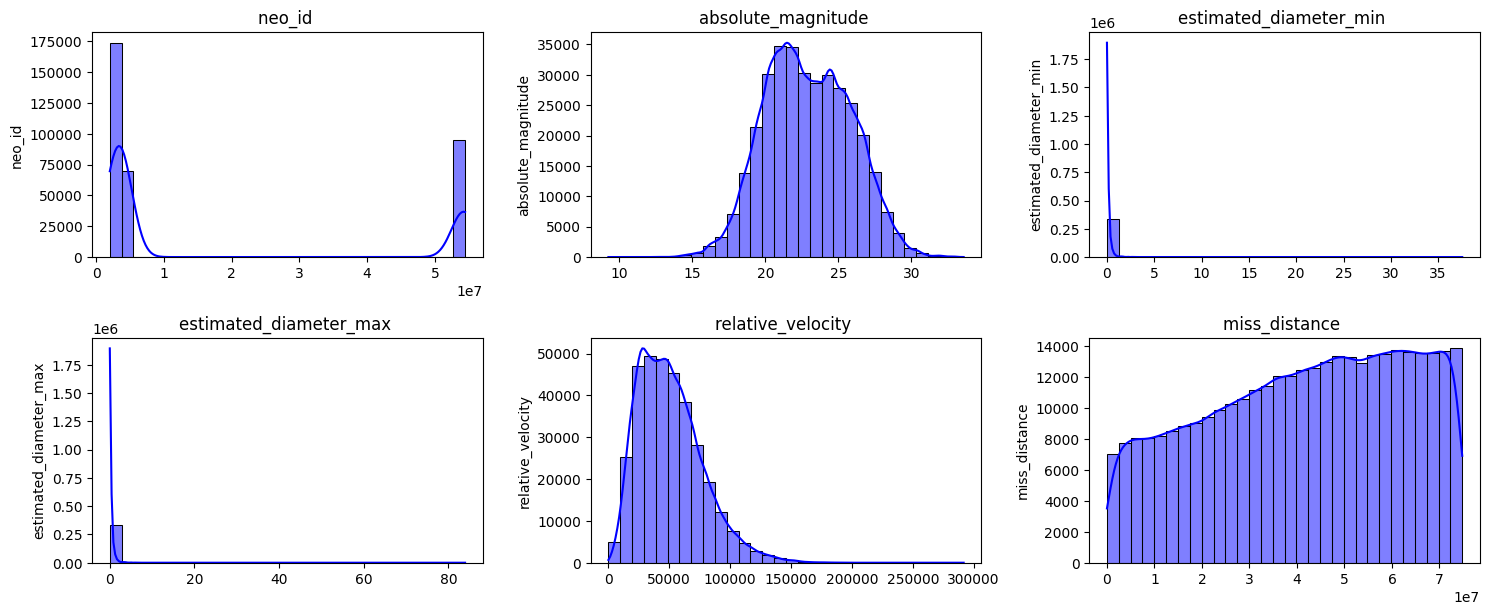

In [14]:
plt.figure(figsize=(15, 15))
for i, feature in enumerate(df.select_dtypes(include='number').columns):
    plt.subplot(5, 3, i+1)
    sns.histplot(data=df, x=feature, bins=30, kde=True, color='blue')
    plt.title(f'{feature} ')
    plt.xlabel(' ')
    plt.ylabel(feature)
plt.tight_layout()

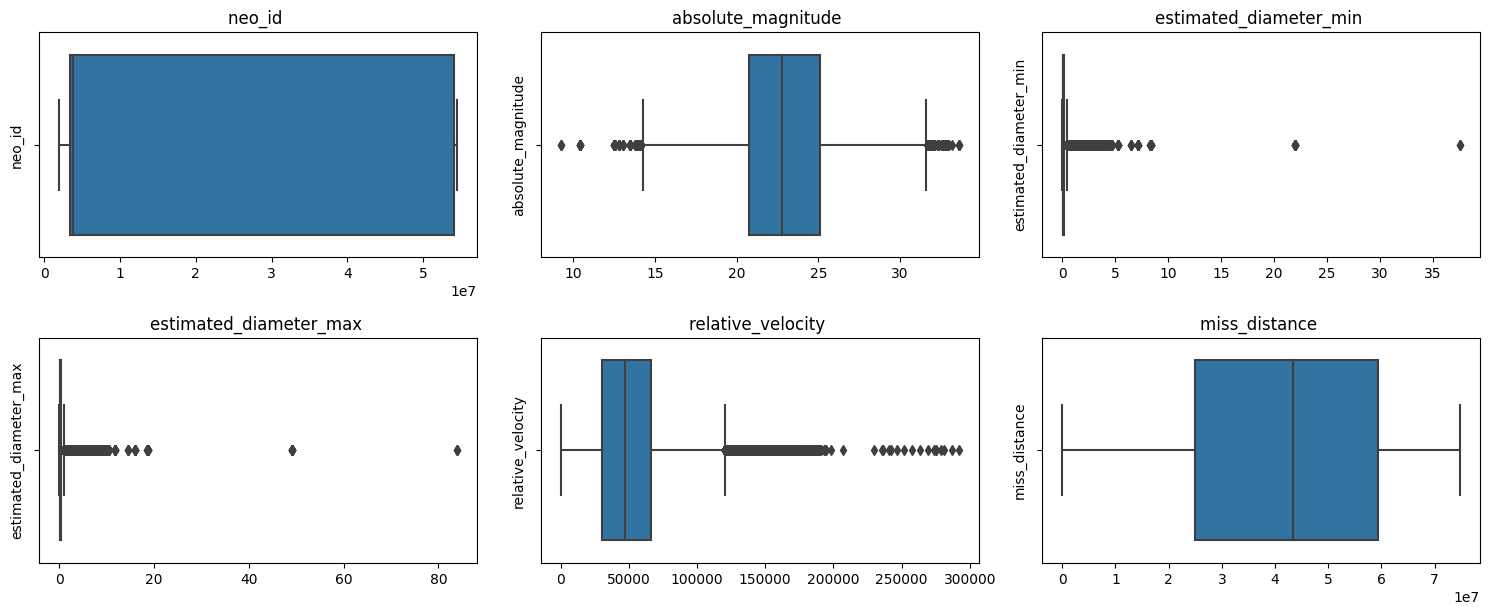

In [15]:
plt.figure(figsize=(15, 15))
for i, feature in enumerate(df.select_dtypes(include='number').columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(data=df, x=feature)
    plt.title(f'{feature} ')
    plt.xlabel(' ')
    plt.ylabel(feature)
plt.tight_layout()

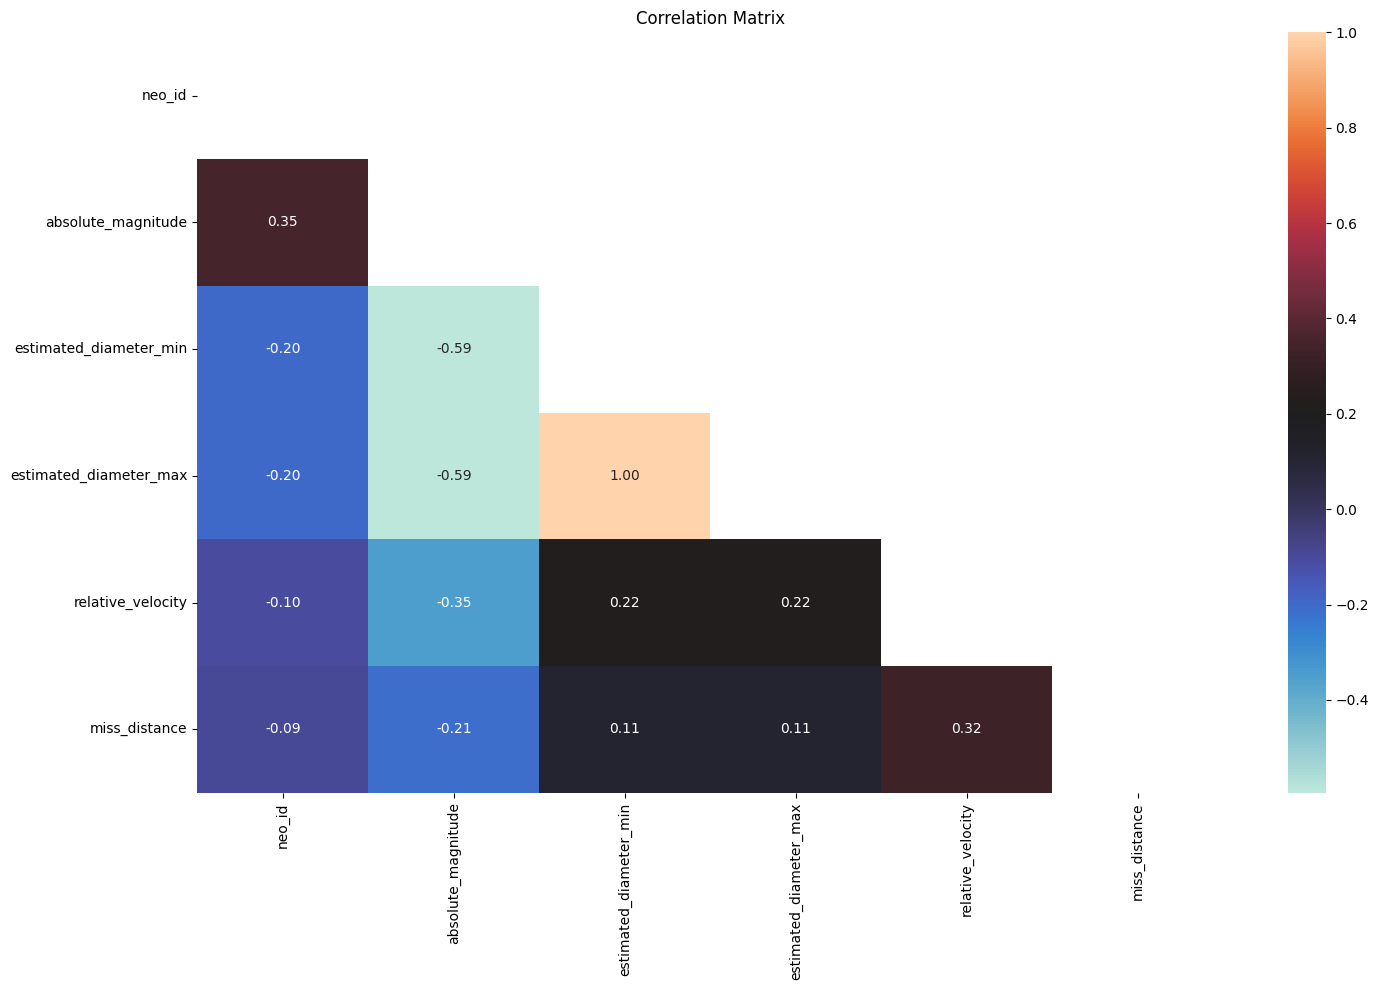

In [16]:
corr = df.select_dtypes(include='number').corr()
mask_ut = np.triu(np.ones(corr.shape)).astype(np.bool_)

plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="icefire", mask=mask_ut)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Missing Values Treatment

In [17]:
df.dropna(inplace=True)

# Outliers Treatment

In [18]:
def remove_outliers(feature):
    global df
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.65)
    iqr = q3 - q1

    upper_limit = q3 + (1.5 * iqr)
    lower_limit = q1 - (1.5 * iqr)

    df = df.loc[(df[feature] < upper_limit) & (df[feature] > lower_limit)]

In [19]:
features_list = ["absolute_magnitude", "estimated_diameter_min", "estimated_diameter_max", "relative_velocity"]

for feature in features_list:
    remove_outliers(feature)

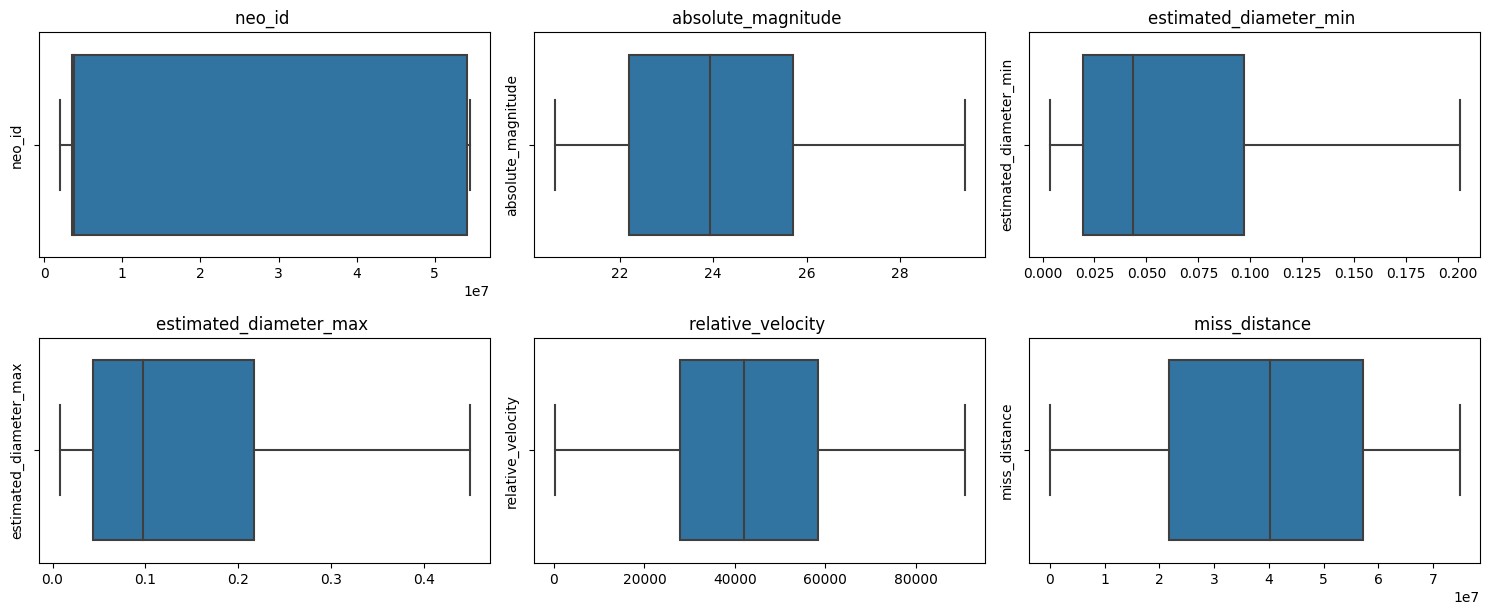

In [20]:
plt.figure(figsize=(15, 15))
for i, feature in enumerate(df.select_dtypes(include='number').columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(data=df, x=feature)
    plt.title(f'{feature} ')
    plt.xlabel(' ')
    plt.ylabel(feature)
plt.tight_layout()

# Feature Selection

In [21]:
X = df.drop(["neo_id", "name", "orbiting_body", "is_hazardous"], axis=1)

y = df["is_hazardous"]

# Handling Imblance Dataset

In [22]:
somte = SMOTE(random_state=42)

X, y = somte.fit_resample(X, y)

y.value_counts()

is_hazardous
False    225477
True     225477
Name: count, dtype: int64

# Train Test Split

In [32]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((360763, 5), (360763,), (90191, 5), (90191,))

# Model Building

In [33]:
clf = RandomForestClassifier(random_state=42)

In [34]:
clf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

# Evaluation

In [35]:
y_pred = clf.predict(x_test)

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.97      0.97     45096
        True       0.97      0.97      0.97     45095

    accuracy                           0.97     90191
   macro avg       0.97      0.97      0.97     90191
weighted avg       0.97      0.97      0.97     90191



In [37]:
print("Acc is: {} %".format(accuracy_score(y_pred, y_test) * 100))

Acc is: 97.1116852014059 %


In [38]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[43788  1308]
 [ 1297 43798]]


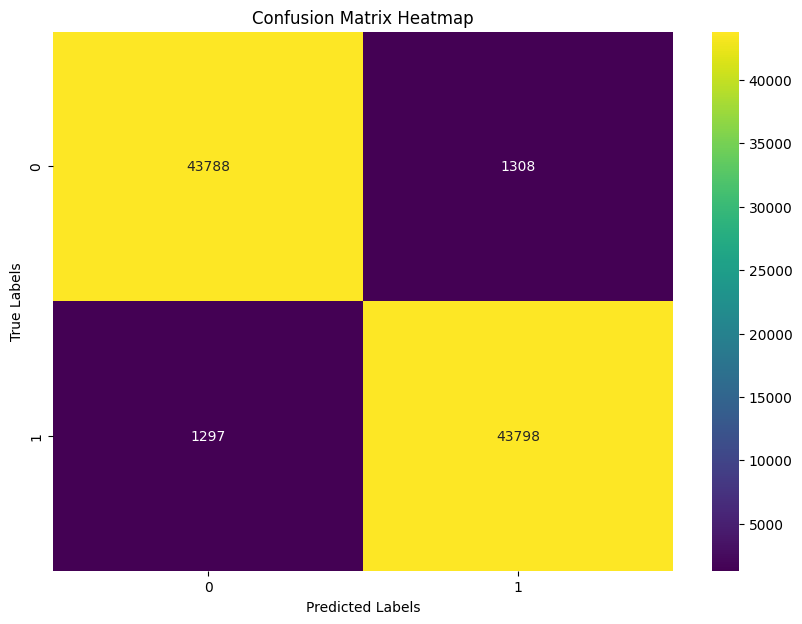

In [39]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

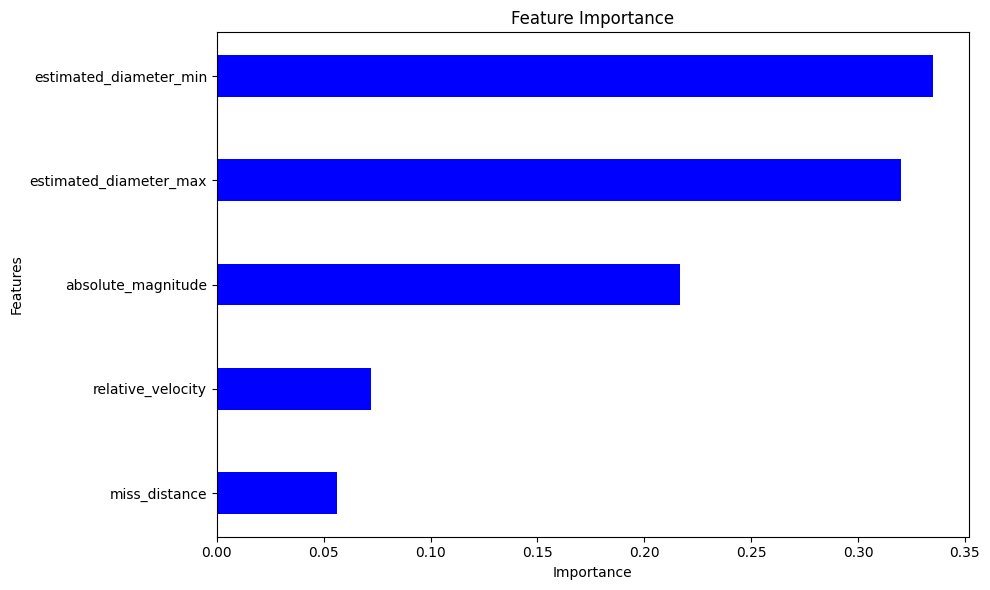

In [40]:
feature_importances = clf.feature_importances_
feature_names = x_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_df['Feature'], importance_df['Importance'], color='blue', height=0.4)
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance')
plt.tight_layout()
plt.show()

# Now Let's plot the learning curve

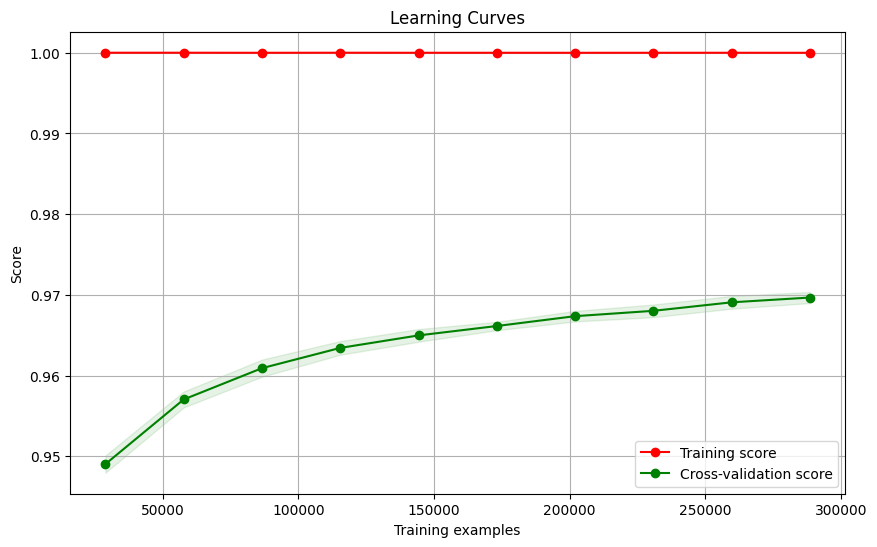

In [41]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    clf, x_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()